Paired TAM (transcient abnormal myleoproliferation) vs AML (acute myeloid leukemia) analysis of patients with the co-occuring condition of Down Syndrome using DESeq2 on IJC counts obtained from rMATS analysis.

Using a matrix constructed from Kids First Workflow V4 done on single runs, a series of scripts were created and are stored in this repository.  For each of the splicing types, all the runs considered for analysis are pooled and normalized to have a non-redundant set of splicing events.  A matrix is then constructed for each of the samples to be analyzed.  

Each splicing type has a bed file for visualizaiton in UCSC Genome browser of all the events, as well as created a matrix of the single runs normalized to the non-redundant union of files.  Both the source and the normalized bed file are available to ensure interprebility of results. 

Using associative arrays in an awk script, it was a rapid way to transform the individual counts from each of the individual runs into a matrix that facilitated analysis.

Using annotations obtained from the rMATS run that provided the coordinates of each of the splicing events as well as the gene that the junctions came from and the count of the reads that overlapped the junctions.   
 
Limma in this notebook is used to perform analysis of these junction counts provided by the rMATS routine.  Using these counts as junction expression.

Between the splicing event differences and the expression differences, between paired samples, biological functional differences may be obtained.

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")


Bioconductor version '3.18' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install



The viper tools are installed from the command line using `conda install` functions


In [2]:
library(mixtools)

mixtools package, version 2.0.0, Released 2022-12-04
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772 and the Chan Zuckerberg Initiative: Essential Open Source Software for Science (Grant No. 2020-255193).




In [3]:
library(bcellViper)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




In [4]:
library(MASS)

In [5]:
library("viper")

In [6]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'bbmle', 'BH', 'BiocManager', 'bslib', 'cachem', 'coda',
  'codetools', 'cpp11', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'edgeR',
  'evaluate', 'farver', 'fastmap', 'GenomeInfoDb', 'ggplot2', 'gtable',
  'highr', 'htmlwidgets', 'KernSmooth', 'knitr', 'lifecycle', 'munsell',
  'mvtnorm', 'openssl', 'plotly', 'RcppArmadillo', 'repr', 'rlang',
  'rmarkdown', 'S4Arrays', 'scales', 'segmented', 'SparseArray', 'stringi',
  'stringr', 'tidyselect', 'tinytex', 'withr', 'xfun', 'zlibbioc'



In [7]:
library(Glimma)
library(dplyr)
library(edgeR)


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA




In [12]:
setwd("/Users/annedeslattesmays/Desktop/projects/post-rmats-single-run/paired.TAM.AMLv2/A3SS_calculate")


In [13]:
getwd()


[1] "/Users/annedeslattesmays/Desktop/projects/post-rmats-single-run/paired.TAM.AMLv2/A3SS_calculate"

In [14]:
cts <- as.matrix(read.csv("A3SS.IJC.w.coordinates.matrix.csv",sep=",",row.names="ID"))

In [15]:
cts[1:3,11:dim(cts)[2]]

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,0,151,0,0,0,0,0,0,0,0
2,36,46,21,10,83,45,50,52,41,69
3,0,0,22,0,0,0,50,0,0,0


In [16]:
featureData <- data.frame(cts[,1:10])
featureData[1:3,]

,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761,chr1,+,100078450,100080659,100080495,100080659,100077164,100077277
2,ENSG00000137996.13,RTCA,chr1,+,100268073,100268295,100268151,100268295,100266523,100266624
3,ENSG00000137996.13,RTCA,chr1,+,100268073,100268295,100268151,100268295,100267165,100267245


In [17]:
featureData <- featureData[,c(1,2)]

In [18]:
head(featureData,2)

,GeneID,geneSymbol
,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761
2,ENSG00000137996.13,RTCA


In [19]:
cts <- data.matrix(cts[,11:20])
mode(cts) <- "integer"
is.integer(cts)

[1] TRUE

In [20]:
dim(cts)
head(cts,2)

[1] 10452    10

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,0,151,0,0,0,0,0,0,0,0
2,36,46,21,10,83,45,50,52,41,69


In [21]:
colnames(cts) <- c("PAUVKY.03A","PAUVKY.40A","PAWHSD.03A","PAWHSD.40A","PAWSNZ.03A","PAWSNZ.40A","PAUTLA.03A","PAUTLA.40A","PAVUDU.03A","PAVUDU.40A")

The PAWHSD samples are not TAM and AML but in fact TAM and TAM - the resulting heatmap when included showed they clustered together.  We will eliminate them from subsequent analyses.

In [22]:
cts <- cts[,-c(3,4)]

In [23]:
head(cts,2)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
1,0,151,0,0,0,0,0,0
2,36,46,83,45,50,52,41,69


In [24]:
# Condition 1: Rows with count > 1000 in columns 1, 3, 5, 7
TAM_rows_condition <- rowSums(cts[, c(1, 3, 5, 7)] > 1000) > 0
TAM_matrix<- cts[TAM_rows_condition, c(1, 3, 5, 7)]

# Condition 2: Rows with count > 1000 in columns 2, 4, 6, 8
AML_rows_condition <- rowSums(cts[, c(2, 4, 6, 8)] > 1000) > 0
AML_matrix <- cts[AML_rows_condition, c(2, 4, 6, 8)]

# Combine the sub-matrices by keeping rows that satisfy either condition 1 or condition 2
final_matrix <- cts[AML_rows_condition | TAM_rows_condition, ]

# View the dimensions of the resulting matrices
dim(TAM_matrix)
dim(AML_matrix)
dim(final_matrix)


[1] 263   4

[1] 177   4

[1] 294   8

In [25]:
head(TAM_matrix)
head(AML_matrix)
head(final_matrix)

,PAUVKY.03A,PAWSNZ.03A,PAUTLA.03A,PAVUDU.03A
33,782,81,410,1890
204,1062,0,0,0
250,1115,1022,1588,0
284,1056,1604,1087,1225
322,0,0,1054,0
515,852,1043,1471,979


,PAUVKY.40A,PAWSNZ.40A,PAUTLA.40A,PAVUDU.40A
154,342,165,345,1529
250,759,424,0,1191
284,1114,0,745,0
515,729,435,610,1011
519,1470,888,1279,2018
520,771,492,682,1083


,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
33,782,417,81,32,410,662,1890,106
154,859,342,160,165,222,345,246,1529
204,1062,0,0,594,0,875,0,0
250,1115,759,1022,424,1588,0,0,1191
284,1056,1114,1604,0,1087,745,1225,0
322,0,0,0,0,1054,0,0,0


In [26]:
cts <- final_matrix

featureData <- featureData[rownames(cts),]

In [27]:
dim(cts)
dim(featureData)

[1] 294   8

[1] 294   2

In [30]:
coldata <- read.csv("/Users/annedeslattesmays/Desktop/projects/post-rmats-single-run/paired.TAM.AMLv2/design_matrix.csv",row.names=1)

In [31]:
coldata


,patient,condition
,<chr>,<chr>
PAUVKY-03A,PAUVKY,TAM
PAUVKY-40A,PAUVKY,AML
PAWSNZ-03A,PAWSNZ,TAM
PAWSNZ-40A,PAWSNZ,AML
PAUTLA-03A,PAUTLA,TAM
PAUTLA-40A,PAUTLA,AML
PAVUDU-03A,PAVUDU,TAM
PAVUDU-40A,PAVUDU,AML


In [32]:
coldata <- coldata[,c("patient","condition")]
coldata$condition <- factor(coldata$condition)
coldata$patient <- factor(coldata$patient)

In [33]:
rownames(coldata)

[1] "PAUVKY-03A" "PAUVKY-40A" "PAWSNZ-03A" "PAWSNZ-40A" "PAUTLA-03A"
[6] "PAUTLA-40A" "PAVUDU-03A" "PAVUDU-40A"

In [34]:
rownames(coldata) <-sub("-",".",rownames(coldata))

In [35]:
colnames(cts)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [36]:
all(rownames(coldata) %in% colnames(cts))

[1] TRUE

In [37]:
dim(cts)
head(cts,4)
mode(cts) <- "integer"
is.integer(cts)

[1] 294   8

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
33,782,417,81,32,410,662,1890,106
154,859,342,160,165,222,345,246,1529
204,1062,0,0,594,0,875,0,0
250,1115,759,1022,424,1588,0,0,1191


[1] TRUE

In [38]:
# lets look at limma/voom
BiocManager::install("limma")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'limma'”
Old packages: 'bbmle', 'BH', 'BiocManager', 'bslib', 'cachem', 'coda',
  'codetools', 'cpp11', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'edgeR',
  'evaluate', 'farver', 'fastmap', 'GenomeInfoDb', 'ggplot2', 'gtable',
  'highr', 'htmlwidgets', 'KernSmooth', 'knitr', 'lifecycle', 'munsell',
  'mvtnorm', 'openssl', 'plotly', 'RcppArmadillo', 'repr', 'rlang',
  'rmarkdown', 'S4Arrays', 'scales', 'segmented', 'SparseArray', 'stringi',
  'stringr', 'tidyselect', 'tinytex', 'withr', 'xfun', 'zlibbioc'



In [39]:
BiocManager::install("statmod")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'statmod'”
Old packages: 'bbmle', 'BH', 'BiocManager', 'bslib', 'cachem', 'coda',
  'codetools', 'cpp11', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'edgeR',
  'evaluate', 'farver', 'fastmap', 'GenomeInfoDb', 'ggplot2', 'gtable',
  'highr', 'htmlwidgets', 'KernSmooth', 'knitr', 'lifecycle', 'munsell',
  'mvtnorm', 'openssl', 'plotly', 'RcppArmadillo', 'repr', 'rlang',
  'rmarkdown', 'S4Arrays', 'scales', 'segmented', 'SparseArray', 'stringi',
  'stringr', 'tidyselect', 'tinytex', 'withr', 'xfun', 'zlibbioc'



In [40]:
library(limma)
library(edgeR)
library(statmod)

In [41]:
# making a counts matrix
dge <- DGEList(counts=cts)

In [42]:
colnames(dge)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [43]:
head(dge,2)

An object of class "DGEList"
$counts
    PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
33         782        417         81         32        410        662
154        859        342        160        165        222        345
    PAVUDU.03A PAVUDU.40A
33        1890        106
154        246       1529

$samples
           group lib.size norm.factors
PAUVKY.03A     1   498999            1
PAUVKY.40A     1   346378            1
PAWSNZ.03A     1   610836            1
PAWSNZ.40A     1   222102            1
PAUTLA.03A     1   811198            1
PAUTLA.40A     1   314848            1
PAVUDU.03A     1   539869            1
PAVUDU.40A     1   574522            1

In [44]:
design <- model.matrix(~ 0 + factor(c(1,2,1,2,1,2,1,2)))
colnames(design) <- c("TAM","AML")

In [45]:
design

,TAM,AML
1,1,0
2,0,1
3,1,0
4,0,1
5,1,0
6,0,1
7,1,0
8,0,1


In [46]:
# normalize and filter
keep          <-filterByExpr(dge, design)

In [47]:
is.logical(keep)
sum(keep==TRUE)

[1] TRUE

[1] 225

In [48]:
dge          <- dge         [keep,,keep.lib.size=FALSE]

In [49]:
# apply scale normalization
dge          <- calcNormFactors(dge)

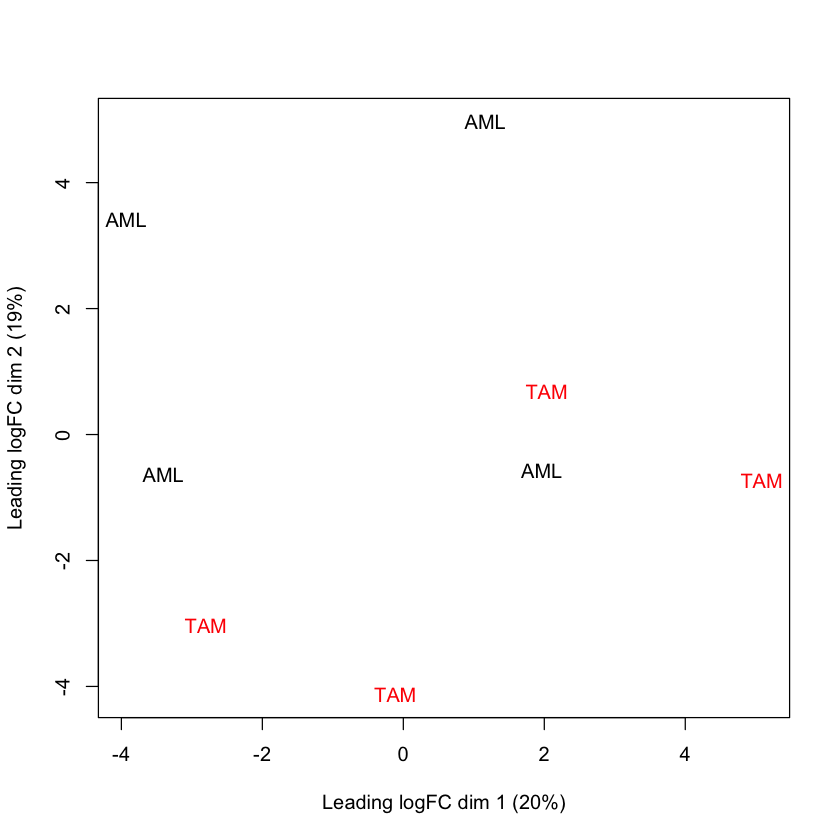

In [50]:
# MDS Plot - can we separate the samples well?
logCPM <- cpm(dge, log=TRUE, prior.count=3)
plotMDS(logCPM,labels=coldata$condition,top=10, col=c(rep(c("red","black"),3)))

In [51]:
head(logCPM)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
33,10.76416,10.215896,7.266772,7.269456,9.323739,11.133738,11.790244,7.551136
154,10.89916,9.931601,8.217962,9.585101,8.451216,10.197396,8.866462,11.353497
250,11.27433,11.076333,10.865957,10.939099,11.266177,2.723952,2.723952,10.994116
284,11.19611,11.628503,11.514382,2.723952,10.721101,11.303675,11.166099,2.723952
515,10.88739,11.018333,10.895198,10.975927,11.156071,11.016078,10.843740,10.758557
519,11.96381,12.027840,11.977814,12.003055,12.372572,12.081803,11.990532,11.752952


In [52]:
head(dge,2)

An object of class "DGEList"
$counts
    PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
33         782        417         81         32        410        662
154        859        342        160        165        222        345
    PAVUDU.03A PAVUDU.40A
33        1890        106
154        246       1529

$samples
           group lib.size norm.factors
PAUVKY.03A     1   471505    0.9572657
PAUVKY.40A     1   338404    1.0418927
PAWSNZ.03A     1   577395    0.9517729
PAWSNZ.40A     1   205759    1.0530969
PAUTLA.03A     1   698609    0.9253794
PAUTLA.40A     1   302515    0.9767762
PAVUDU.03A     1   511191    1.0458436
PAVUDU.40A     1   553599    1.0581839

In [53]:
fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)
de_results <- topTable(fit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 225

[1] "RACK1" "RACK1" "RPS7"  "RPL7A" "RPL4"  "RACK1"

In [54]:
# There are too many values - lets reduce the size a bit more
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 5
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 221   6

In [55]:
lookup <- rownames(significant_genes)
df <- as.data.frame(coldata[,c("condition","patient")])

significant_expression <- dge[lookup,]
dim(significant_expression)
length(lookup)

[1] 221   8

[1] 221

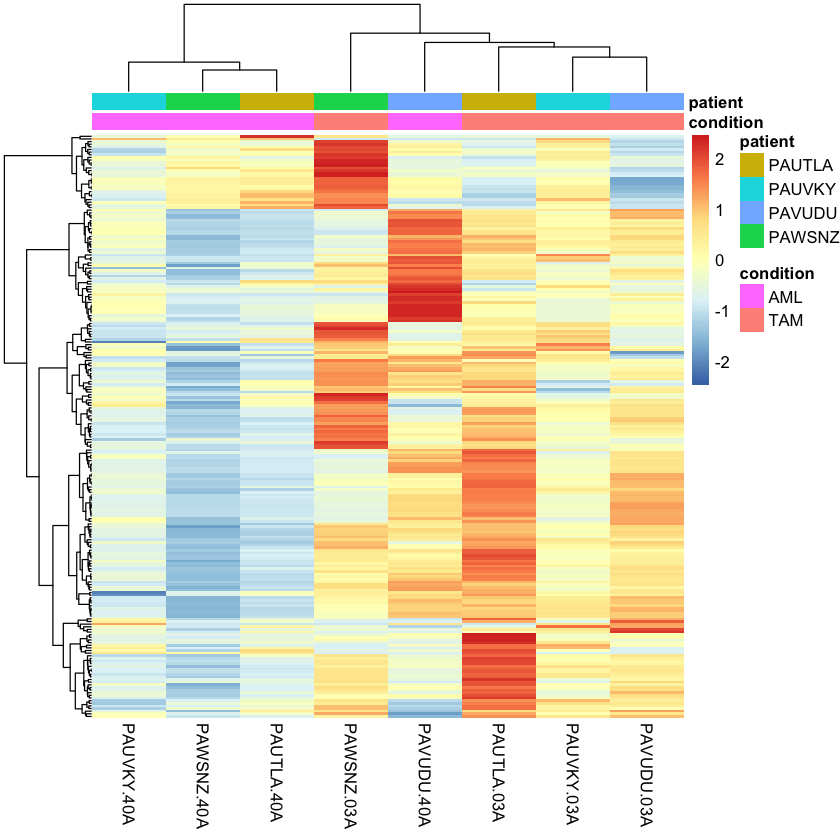

In [56]:
library("pheatmap")

significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

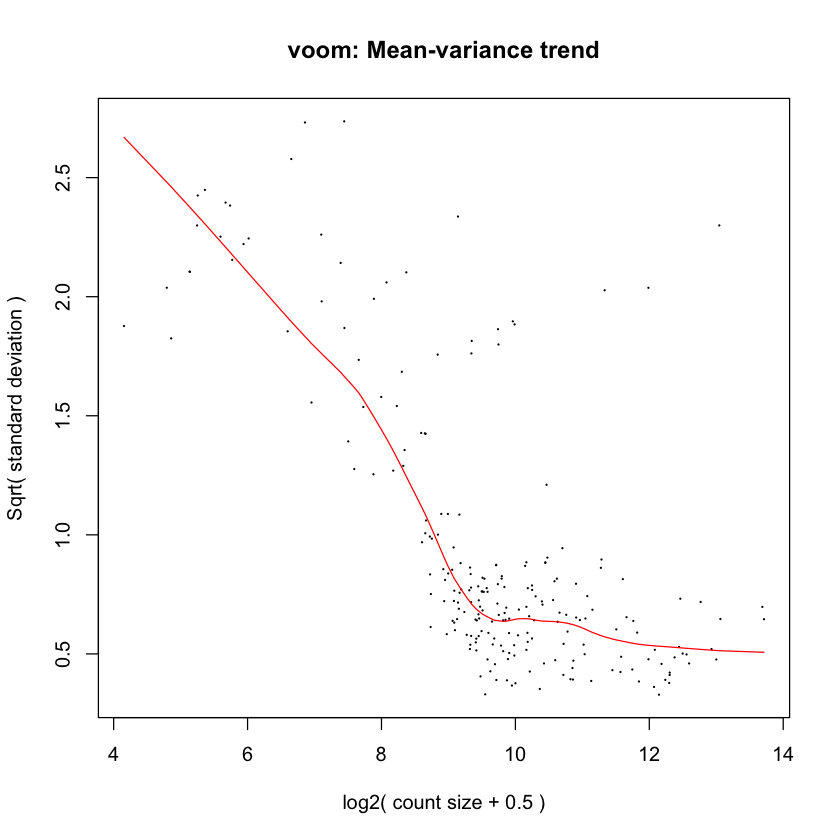

In [57]:
# weighting 
v <- voom(dge, plot=TRUE, normalize="quantile")

In [58]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)
de_results <- topTable(vfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 225

[1] "RACK1"  "RPS7"   "RPL4"   "RPL7A"  "PABPC1" "PABPC1"

In [59]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 200   6

In [60]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

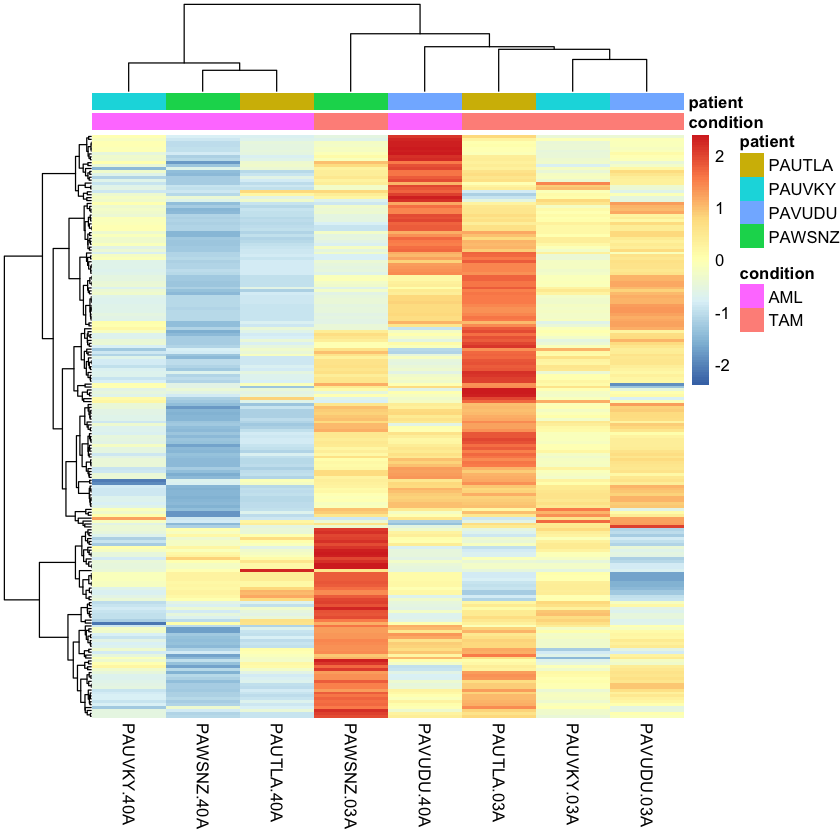

In [61]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [62]:
featureData[head(rownames(significant_expression),5),2]

[1] "RACK1"  "RPS7"   "RPL4"   "RPL7A"  "PABPC1"

In [63]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 200

In [64]:
top_significant_genes <- dge[rownames(significant_genes),]

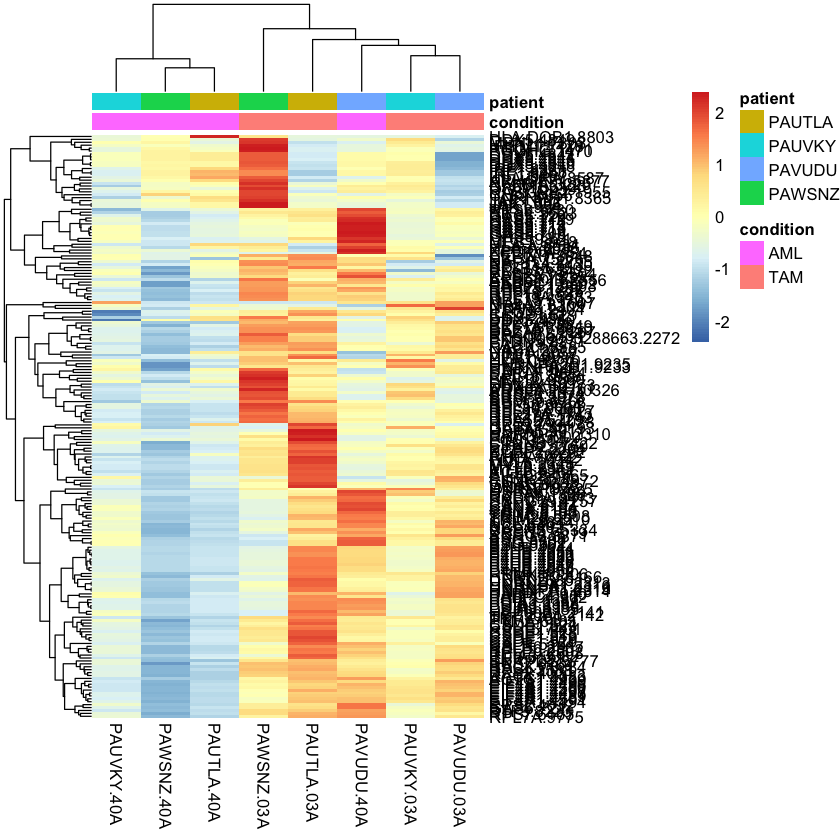

In [65]:
start=1
stop=length(top_gene_list)
date="2024Jun04_SE_voom"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"SE_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [66]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


[1] 200   2

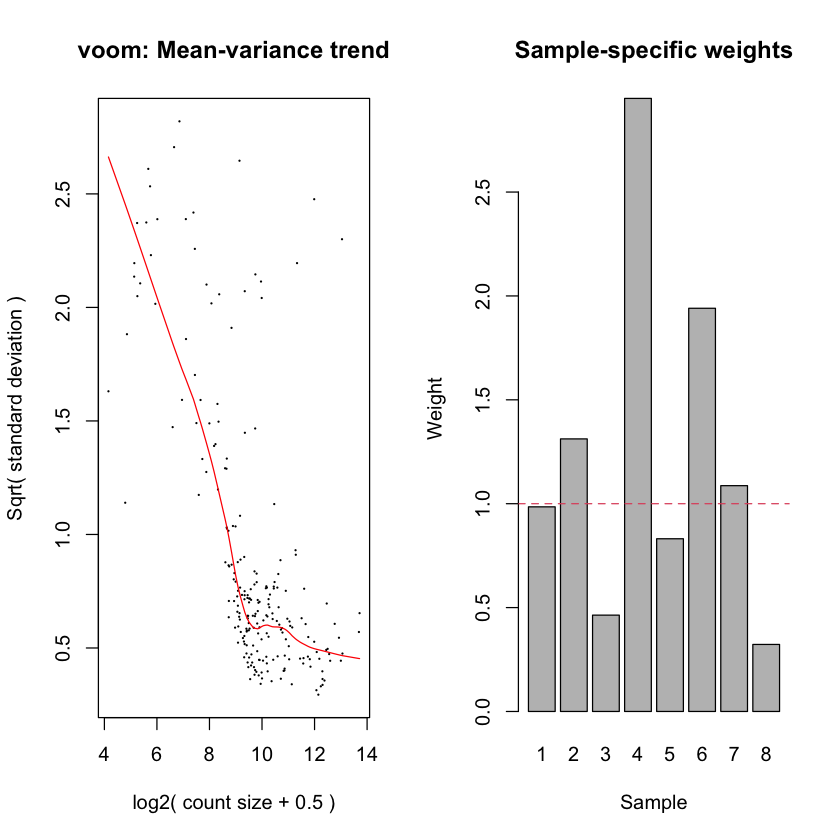

In [67]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [68]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
# no other weighting at this time.
 #* c(1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0))

In [69]:
vwtsfit <- eBayes(vwtsfit, trend=TRUE)
de_results <- topTable(vwtsfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 225

[1] "PABPC1" "PABPC1" "PTMA"   "RPS7"   "RACK1"  "RPL7A"

In [70]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 196   6

In [71]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

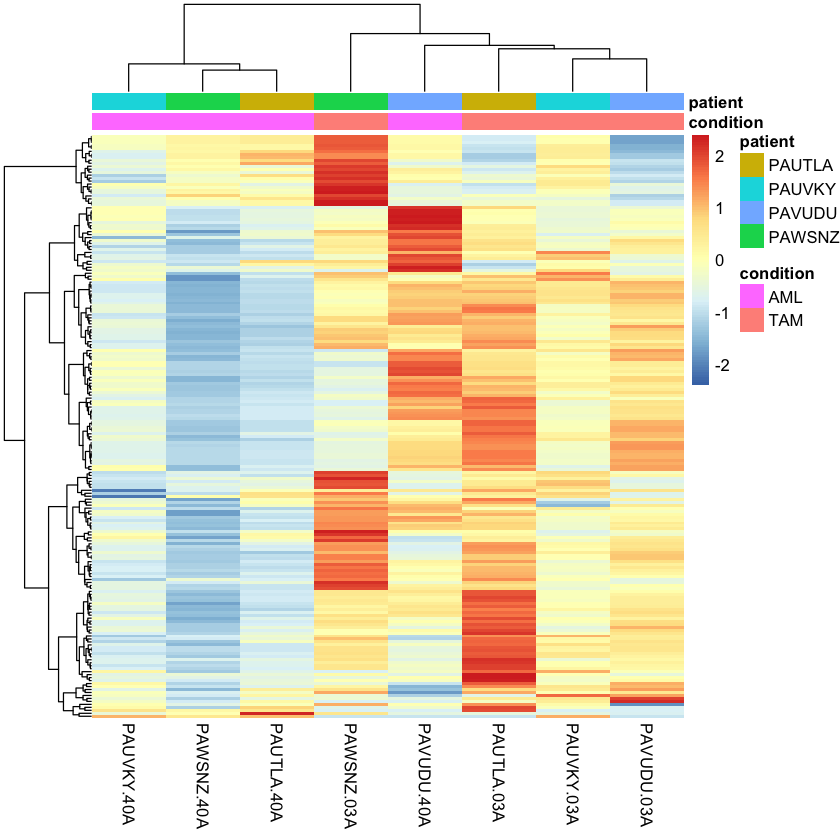

In [72]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [73]:
featureData[head(rownames(significant_expression),5),2]

[1] "PABPC1" "PABPC1" "PTMA"   "RPS7"   "RACK1"

In [74]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 196

In [75]:
top_significant_genes <- dge[rownames(significant_genes),]

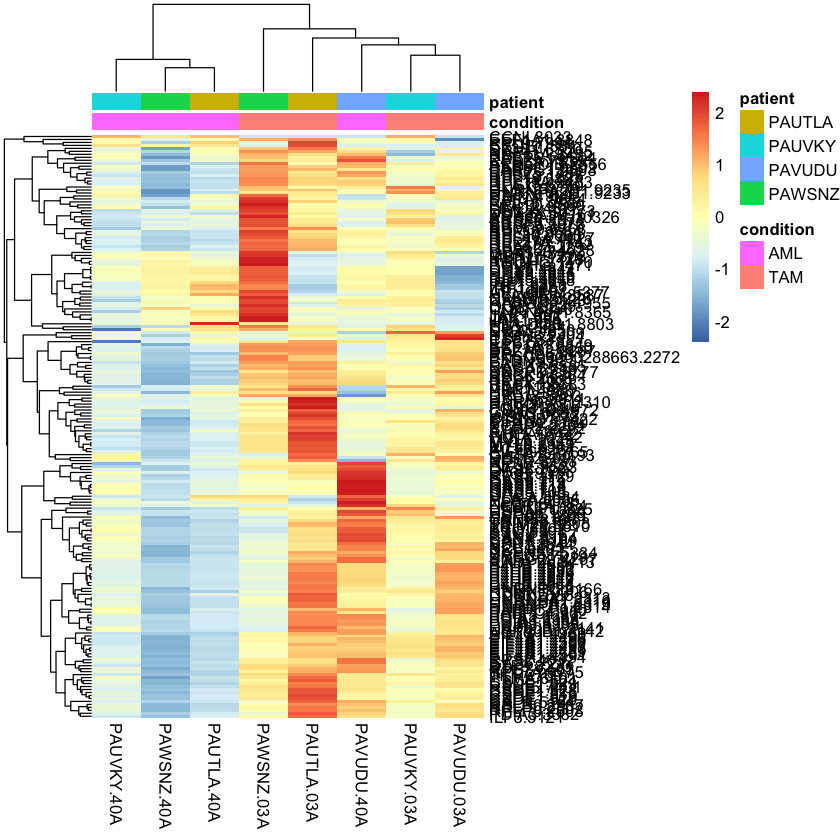

In [77]:
start=1
stop=length(top_gene_list)
date="2024Jun04_SE_vwts"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"SE_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [79]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(outpiece, "2024Jun04_SE_vwts_10fold_top_significant_genes.pdf")

pdf 
  2

In [80]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


[1] 196   2